In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pickle

# load sae features

In [3]:
file_path = '/content/drive/MyDrive/fActs_ts_1L_21M_sheHer.pkl'
with open(file_path, 'rb') as f:
    feature_acts = pickle.load(f)

In [18]:
feature_acts.shape

torch.Size([195, 128, 16384])

# pca

In [5]:
from sklearn.decomposition import PCA

# Reshape feature_acts to (batch * seqlen, featuredim)
batch, seqlen, featuredim = feature_acts.shape
reshaped_acts = feature_acts.view(batch * seqlen, featuredim).detach().cpu().numpy()

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)
filtered_acts = pca.fit_transform(reshaped_acts)

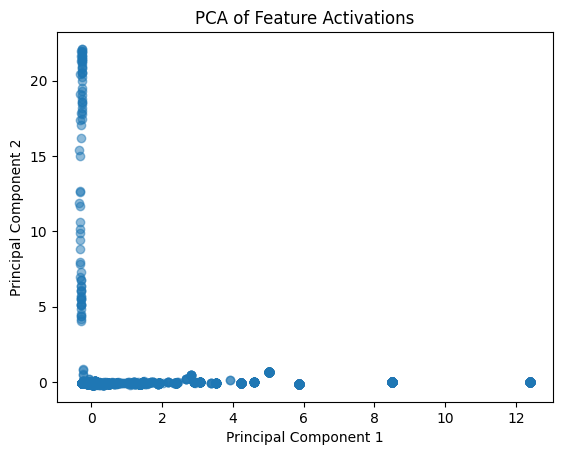

In [17]:
# Plot the PCA results
plt.scatter(filtered_acts[:, 0], filtered_acts[:, 1], alpha=0.5)
plt.title("PCA of Feature Activations")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# mapper

In [6]:
from sklearn.cluster import DBSCAN
import numpy as np

# Define filter function and create open cover
def create_cover(filtered, intervals, overlap):
    min_val, max_val = np.min(filtered, axis=0), np.max(filtered, axis=0)
    steps = (max_val - min_val) / (intervals - 1) * (1 + overlap)
    cover = []
    for i in range(intervals):
        for j in range(intervals):
            cover.append(((min_val[0] + i * steps[0], min_val[0] + (i + 1) * steps[0]),
                          (min_val[1] + j * steps[1], min_val[1] + (j + 1) * steps[1])))
    return cover

cover = create_cover(filtered_acts, intervals=10, overlap=0.1)

# Apply clustering within cover sets
def cluster_cover(cover, filtered, activations):
    clusters = []
    for (x_range, y_range) in cover:
        indices = np.where((filtered[:, 0] >= x_range[0]) & (filtered[:, 0] < x_range[1]) &
                           (filtered[:, 1] >= y_range[0]) & (filtered[:, 1] < y_range[1]))[0]
        if len(indices) > 0:
            clustering = DBSCAN().fit(activations[indices])
            clusters.append((indices, clustering.labels_))
    return clusters

clusters = cluster_cover(cover, filtered_acts, reshaped_acts)

In [7]:
import networkx as nx

# Construct mapper graph
def construct_mapper_graph(clusters):
    G = nx.Graph()
    for idx, (indices, labels) in enumerate(clusters):
        for label in np.unique(labels):
            if label != -1:
                cluster_indices = indices[labels == label]
                G.add_node((idx, label), members=cluster_indices)
    for i, (indices1, labels1) in enumerate(clusters):
        for j, (indices2, labels2) in enumerate(clusters):
            if i < j:
                common_indices = np.intersect1d(indices1, indices2)
                if len(common_indices) > 0:
                    for label1 in np.unique(labels1):
                        if label1 != -1:
                            members1 = indices1[labels1 == label1]
                            for label2 in np.unique(labels2):
                                if label2 != -1:
                                    members2 = indices2[labels2 == label2]
                                    if len(np.intersect1d(members1, members2)) > 0:
                                        G.add_edge((i, label1), (j, label2))
    return G

mapper_graph = construct_mapper_graph(clusters)


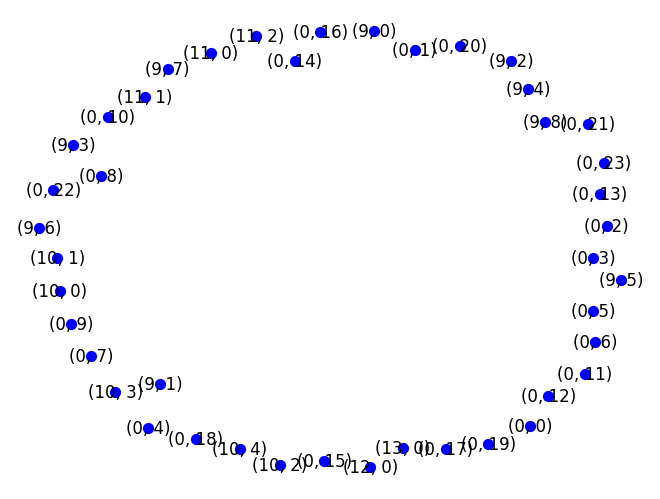

In [8]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(mapper_graph)
nx.draw(mapper_graph, pos, with_labels=True, node_size=50, node_color="blue")
plt.show()

# compare to random

In [9]:
random_data = np.random.randn(*feature_acts.shape)

In [10]:
batch, seqlen, featuredim = random_data.shape
reshaped_random_data = random_data.reshape(batch * seqlen, featuredim)
filtered_random_data = pca.transform(reshaped_random_data)

In [11]:
random_cover = create_cover(filtered_random_data, intervals=10, overlap=0.1)
random_clusters = cluster_cover(random_cover, filtered_random_data, reshaped_random_data)
random_mapper_graph = construct_mapper_graph(random_clusters)

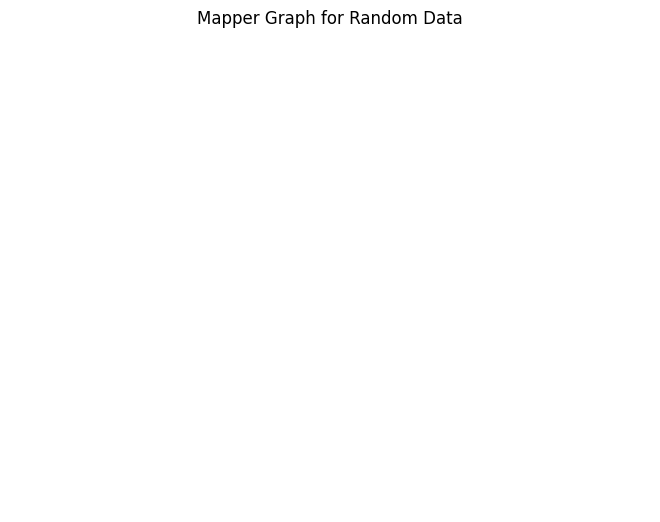

In [12]:
pos_random = nx.spring_layout(random_mapper_graph)
nx.draw(random_mapper_graph, pos_random, with_labels=True, node_size=50, node_color="red")
plt.title("Mapper Graph for Random Data")
plt.show()

In [15]:
# Check shapes and intermediate results
print("Random Data Shape:", random_data.shape)
print("Reshaped Random Data Shape:", reshaped_random_data.shape)
print("Filtered Random Data Shape:", filtered_random_data.shape)
print("Num clusters:", len(random_clusters))

# Check cluster details
for idx, (indices, labels) in enumerate(random_clusters):
    print(f"Cluster {idx}: {len(indices)} points, labels: {np.unique(labels)}")

# Check graph info
# print(nx.info(random_mapper_graph))

Random Data Shape: (195, 128, 16384)
Reshaped Random Data Shape: (24960, 16384)
Filtered Random Data Shape: (24960, 2)
Num clusters: 61
Cluster 0: 3 points, labels: [-1]
Cluster 1: 2 points, labels: [-1]
Cluster 2: 11 points, labels: [-1]
Cluster 3: 18 points, labels: [-1]
Cluster 4: 8 points, labels: [-1]
Cluster 5: 1 points, labels: [-1]
Cluster 6: 6 points, labels: [-1]
Cluster 7: 62 points, labels: [-1]
Cluster 8: 172 points, labels: [-1]
Cluster 9: 199 points, labels: [-1]
Cluster 10: 83 points, labels: [-1]
Cluster 11: 25 points, labels: [-1]
Cluster 12: 2 points, labels: [-1]
Cluster 13: 6 points, labels: [-1]
Cluster 14: 74 points, labels: [-1]
Cluster 15: 458 points, labels: [-1]
Cluster 16: 1077 points, labels: [-1]
Cluster 17: 1137 points, labels: [-1]
Cluster 18: 549 points, labels: [-1]
Cluster 19: 115 points, labels: [-1]
Cluster 20: 6 points, labels: [-1]
Cluster 21: 17 points, labels: [-1]
Cluster 22: 201 points, labels: [-1]
Cluster 23: 988 points, labels: [-1]
Cluster